In [3]:
import sys
import os


current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from skimage.feature import hog
import random
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [5]:
# Hyperparameter
max_depth = 15
output_dim = 8
BATCH_SIZE = 32

In [6]:
def extract_hog_features(image):
    hog_features = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=False
    )
    return hog_features

In [7]:
# load datasets
full_data = pd.read_csv('../data/legend.csv')
full_data['label_idx'] = full_data['emotion'].str.lower()

unique_labels = sorted(full_data['label_idx'].unique())
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
full_data['label_idx'] = full_data['label_idx'].map(label_to_int)
print(f"Labels: {unique_labels}")

# split datasets
train_df, val_df = train_test_split(
    full_data, test_size=0.2, stratify=full_data['emotion'], random_state=42)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

Labels: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
Training samples: 10952, Validation samples: 2738


In [8]:
def extract_features_from_df(df, image_root):
    X, y = [], []

    for _, row in df.iterrows():
        # FIXED: use the correct column name
        image_filename = row['image']      
        label_idx = row['label_idx']

        image_path = os.path.join(image_root, image_filename)

        # load image
        img = cv2.imread(image_path)
        if img is None:
            print("Warning: could not read:", image_path)
            continue
        
        # preprocess for HOG
        img_resized = cv2.resize(img, (128, 128))
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

        # extract features
        hog_features = extract_hog_features(img_gray)

        X.append(hog_features)
        y.append(label_idx)

    return np.array(X), np.array(y)


In [9]:
X_train, y_train = extract_features_from_df(train_df, '../images/')
X_val, y_val = extract_features_from_df(val_df, '../images/')

In [32]:
training_loss = []
training_acc = []
val_loss = []
val_accuracy = []
print("Start Training RandomForest...")

for depth in range(1, max_depth+1):
    rf = RandomForestClassifier(n_estimators=200, max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)

    train_probs = rf.predict_proba(X_train)
    train_preds = rf.predict(X_train)

    train_acc = accuracy_score(y_train, train_preds)
    train_loss = log_loss(y_train, train_probs)

    training_acc.append(train_acc)
    training_loss.append(train_loss)

    val_probs = rf.predict_proba(X_val)
    val_preds = rf.predict(X_val)

    val_acc = accuracy_score(y_val, val_preds)
    val_l = log_loss(y_val, val_probs)

    val_accuracy.append(val_acc)
    val_loss.append(val_l)
    print(f"Depth={depth:2d} | "
          f"Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f} | "
          f"Train Loss={train_loss:.4f} | Val Loss={val_l:.4f}")

Start Training RandomForest...
Depth= 1 | Train Acc=0.6526 | Val Acc=0.6552 | Train Loss=0.9788 | Val Loss=0.9820
Depth= 2 | Train Acc=0.7287 | Val Acc=0.7286 | Train Loss=0.9335 | Val Loss=0.9389
Depth= 3 | Train Acc=0.7552 | Val Acc=0.7538 | Train Loss=0.8903 | Val Loss=0.9003
Depth= 4 | Train Acc=0.7713 | Val Acc=0.7560 | Train Loss=0.8493 | Val Loss=0.8683
Depth= 5 | Train Acc=0.7957 | Val Acc=0.7703 | Train Loss=0.8016 | Val Loss=0.8401
Depth= 6 | Train Acc=0.8249 | Val Acc=0.7739 | Train Loss=0.7392 | Val Loss=0.8172
Depth= 7 | Train Acc=0.8588 | Val Acc=0.7779 | Train Loss=0.6591 | Val Loss=0.7972
Depth= 8 | Train Acc=0.8842 | Val Acc=0.7823 | Train Loss=0.5669 | Val Loss=0.7804
Depth= 9 | Train Acc=0.9027 | Val Acc=0.7874 | Train Loss=0.4758 | Val Loss=0.7725
Depth=10 | Train Acc=0.9233 | Val Acc=0.7911 | Train Loss=0.3943 | Val Loss=0.7607
Depth=11 | Train Acc=0.9466 | Val Acc=0.7863 | Train Loss=0.3347 | Val Loss=0.7573
Depth=12 | Train Acc=0.9645 | Val Acc=0.7904 | Train Los

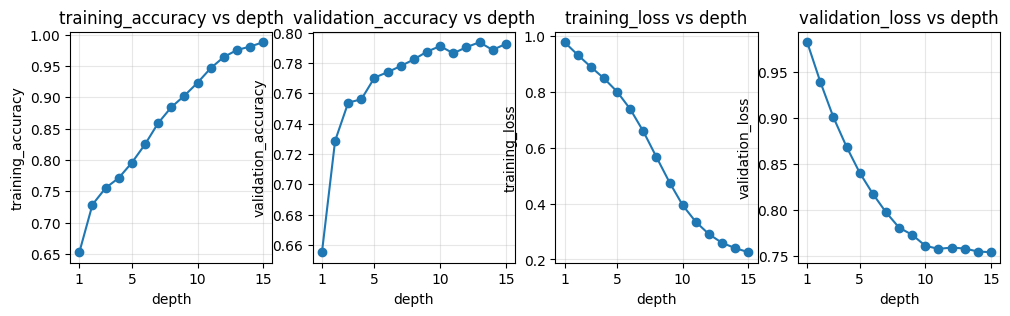

In [33]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].plot(range(1, len(training_acc)+1), training_acc, marker='o')
axes[0].set_xlabel('depth')
axes[0].set_ylabel("training_accuracy")
axes[0].set_title('training_accuracy vs depth')
axes[0].set_xticks([1, 5, 10, 15])
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(val_accuracy)+1), val_accuracy, marker='o')
axes[1].set_xlabel('depth')
axes[1].set_ylabel("validation_accuracy")
axes[1].set_title('validation_accuracy vs depth')
axes[1].set_xticks([1, 5, 10, 15])
axes[1].grid(True, alpha=0.3)

axes[2].plot(range(1, len(training_loss)+1), training_loss, marker='o')
axes[2].set_xlabel('depth')
axes[2].set_ylabel("training_loss")
axes[2].set_title('training_loss vs depth')
axes[2].set_xticks([1, 5, 10, 15])
axes[2].grid(True, alpha=0.3)

axes[3].plot(range(1, len(val_loss)+1), val_loss, marker='o')
axes[3].set_xlabel('depth')
axes[3].set_ylabel("validation_loss")
axes[3].set_title('validation_loss vs depth')
axes[3].set_xticks([1, 5, 10, 15])
axes[3].grid(True, alpha=0.3)

In [10]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
rf.fit(X_train, y_train)
# Predictions from RandomForest
y_pred = rf.predict(X_val)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Normalize confusion matrix per class (%) like your friend’s version
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

print("\nPer-class accuracy:")
for i, label in enumerate(unique_labels):
    print(f"{label}: {cm_normalized[i, i]:.2f}%")

# Weighted F1-score
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"\nWeighted F1-Score: {f1:.4f}")



Per-class accuracy:
anger: 0.00%
contempt: 0.00%
disgust: 0.00%
fear: 0.00%
happiness: 80.77%
neutral: 91.04%
sadness: 0.00%
surprise: 0.00%

Weighted F1-Score: 0.7582
